<a href="https://colab.research.google.com/github/PranavDixit2/LungCancer/blob/main/Programing_Assignment_5_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
from google.colab import drive
drive.mount('/content/drive')
filepath ='drive/MyDrive/AI ML in clinical research/'
list_of_files = os.listdir(filepath)
print(list_of_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Project Proposal V1.gdoc', 'Annotation_Base11.csv', 'Base11']


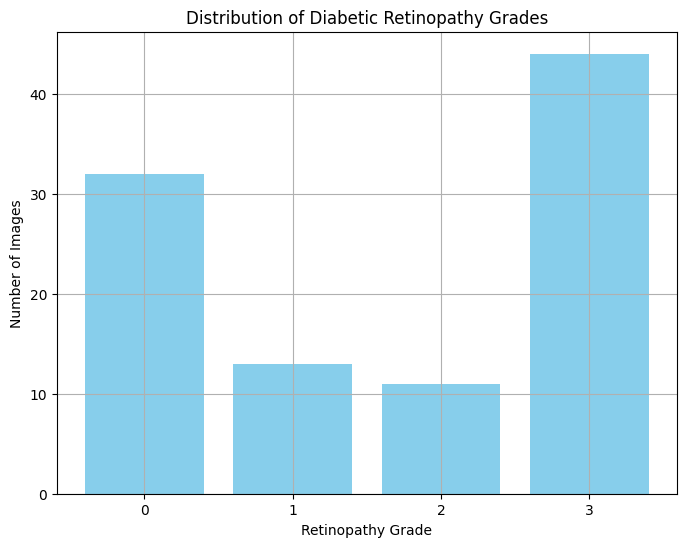

In [11]:
# ------------------------------
# Constants and Configuration
# ------------------------------
IMG_HEIGHT = 74
IMG_WIDTH = 112
BATCH_SIZE = 16
EPOCHS = 20  # Limited epochs for CPU training

# Directory where the images are stored and the annotation file path

#########################################################
## Your code here:
## Assign the data folder path to the DATA_DIR variable, and the annotation csv file path to the ANNOTATION_FILE variable
## For example, in my system they are located at:
## DATA_DIR = "/dbfs/FileStore/DR_data/Base11_unzipped/Base11"
## ANNOTATION_FILE = "/dbfs/FileStore/DR_data/Annotation_Base11.csv"

DATA_DIR = "/content/drive/MyDrive/AI ML in clinical research/Base11/Base11"
ANNOTATION_FILE = "/content/drive/MyDrive/AI ML in clinical research/Annotation_Base11.csv"

#########################################################

# ------------------------------
# Load Annotations
# ------------------------------
df = pd.read_csv(ANNOTATION_FILE)
df = df[['Image name', 'Retinopathy grade']]
df['file_path'] = df['Image name'].apply(lambda x: os.path.join(DATA_DIR, x))
file_paths = df['file_path'].tolist()
labels = df['Retinopathy grade'].tolist()
labels = np.array(labels)

# Get class distribution
class_counts = df['Retinopathy grade'].value_counts().sort_index()

# Plot the distribution as a bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index.astype(str), class_counts.values, color='skyblue')
plt.xlabel('Retinopathy Grade')
plt.ylabel('Number of Images')
plt.title('Distribution of Diabetic Retinopathy Grades')
plt.grid('on')
plt.show()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
def inspect_image_dimensions(file_path):
    # Open image using PIL and print dimensions
    image = Image.open(file_path)
    # PIL returns (width, height)
    print(f"Image: {os.path.basename(file_path)}, Dimensions (W x H): {image.size[0]} x {image.size[1]}")

# Print dimensions for first 5 images
print("Original Image Dimensions:")
for fp in file_paths[:5]:
    inspect_image_dimensions(fp)

Original Image Dimensions:
Image: 20051019_38557_0100_PP.tif, Dimensions (W x H): 2240 x 1488
Image: 20051020_43808_0100_PP.tif, Dimensions (W x H): 2240 x 1488
Image: 20051020_43832_0100_PP.tif, Dimensions (W x H): 2240 x 1488
Image: 20051020_43882_0100_PP.tif, Dimensions (W x H): 2240 x 1488
Image: 20051020_43906_0100_PP.tif, Dimensions (W x H): 2240 x 1488


In [14]:
# ------------------------------
# Split the Data
# ------------------------------
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# ------------------------------
# Image Loading Function for TIFF Images using PIL
# ------------------------------
def load_tif_image(file_path):
    # file_path is a byte string tensor; convert it to Python string
    file_path_str = file_path.numpy().decode('utf-8')
    image = Image.open(file_path_str)
    image = image.convert('RGB')  # Ensure 3 channels
    image = np.array(image)
    return image

def load_and_preprocess_image(file_path, label):
    # Use tf.py_function to wrap the PIL loading for TIFF files
    image = tf.py_function(func=load_tif_image, inp=[file_path], Tout=tf.uint8)
    image.set_shape([None, None, 3])  # Set unknown dimensions; will be inferred at runtime

    # Resize image if needed (uncomment the following line if you decide to standardize)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])

    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# ------------------------------
# Create tf.data Datasets
# ------------------------------
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name='input_layer')


#########################################################
## Your code here:
## Create a convolutional layer with 16 filters, 3x3 kernels, and relu activation function, and give it the name: 'conv_layer_1_1'
x = Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv_layer_1_1')(inputs)
#########################################################

#########################################################
## Your code here:
## Create another convolutional layer with 16 filters, 3x3 kernels, and relu activation function, and give it the name: 'conv_layer_1_2'
x = Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv_layer_1_2')(x)
#########################################################

#########################################################
## Your code here:
## Create a max pooling layer with a pool size of (2, 2) and give it the name: 'pool_layer_1'
x = MaxPooling2D(pool_size=(2, 2), name='pool_layer_1')(x)
#########################################################

x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv_layer_2_1')(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv_layer_2_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_layer_2')(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv_layer_3_1')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv_layer_3_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool_layer_3')(x)

#########################################################
## Your code here:
## Create a flatten layer and give it the name: 'flatten'
x = Flatten(name='flatten')(x)
#########################################################

x = Dense(256, activation='relu', name='dense_layer_1')(x)
x = Dense(64, activation='relu', name='dense_layer_2')(x)

#########################################################
## Your code here:
## Create a Dropout layer with a dropout rate of 0.1 and give it the name: 'dropout_layer'
x = Dropout(0.1, name='dropout_layer')(x)
#########################################################

#########################################################
## Your code here:
## Create an output layer with the appropriate number of units based on the total number of classes in your dataset, and the appropriate activation function for multi-class classification and give it the name: 'output_layer'
outputs = Dense(5, activation='softmax', name='output_layer')(x)
#########################################################

model = Model(inputs=inputs, outputs=outputs, name='DR_cnn_classifier')
model.summary()

# ------------------------------
# Compile the Model
# ------------------------------
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "DR_cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 74, 112, 3)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1_1 (Conv2D)              │ (None, 72, 110, 16)         │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_1_2 (Conv2D)              │ (None, 70, 108, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer_1 (MaxPooling2D)          │ (None, 35, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2_1 (Conv2D)              │ (None, 33, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_2_2 (Conv2D)              │ (None, 31, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer_2 (MaxPooling2D)          │ (None, 15, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_3_1 (Conv2D)              │ (None, 13, 23, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_layer_3_2 (Conv2D)              │ (None, 11, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_layer_3 (MaxPooling2D)          │ (None, 5, 10, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 256)                 │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_2 (Dense)                │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer (Dropout)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 908,309 (3.46 MB)

 Trainable params: 908,309 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# ------------------------------
# Train the Model
# ------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 11s/step - accuracy: 0.3170 - loss: 1.5407 - val_accuracy: 0.4500 - val_loss: 1.2934
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4491 - loss: 1.2441 - val_accuracy: 0.4500 - val_loss: 1.2687
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4655 - loss: 1.2502 - val_accuracy: 0.4500 - val_loss: 1.2503
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4431 - loss: 1.2640 - val_accuracy: 0.4500 - val_loss: 1.2620
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4092 - loss: 1.2697 - val_accuracy: 0.4500 - val_loss: 1.2416
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4552 - loss: 1.2024 - val_accuracy: 0.4500 - val_loss: 1.2343
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4191 - loss: 1.2460 - val_accuracy: 0.5000 - val_loss: 1.2424
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4361 - loss: 1.2458 - val_accuracy: 0.4500 - val_loss: 1.2145
Epoch 9/2

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4125 - loss: 1.2359
Validation Loss: 1.2533775568008423
Validation Accuracy: 0.4000000059604645


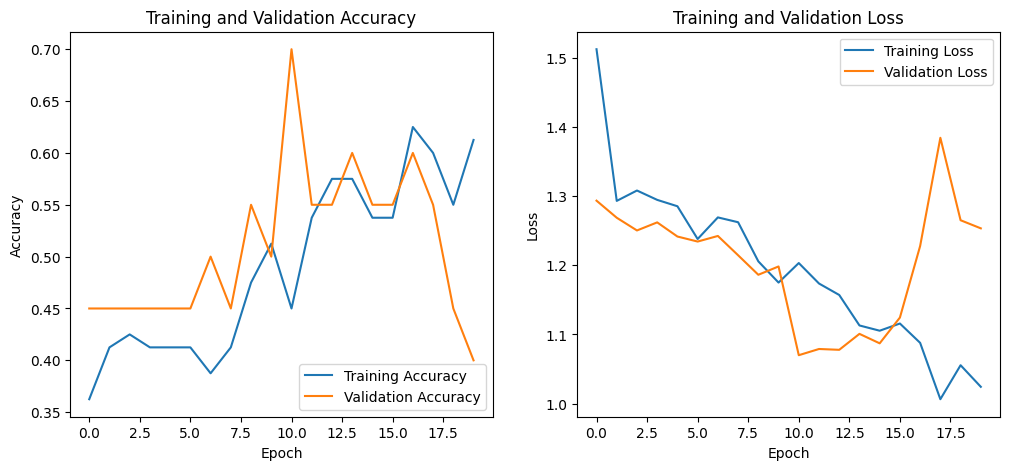

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Confusion Matrix:
[[1 0 2 3]
 [0 0 0 3]
 [0 0 0 2]
 [1 1 0 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.47      0.78      0.58         9

    accuracy                           0.40        20
   macro avg       0.24      0.24      0.21        20
weighted avg       0.36      0.40      0.34        20



In [17]:
# ------------------------------
# Evaluate the Model
# ------------------------------
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# ------------------------------
# Plot Training History
# ------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_values = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_values, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")
plt.show()

# ------------------------------
# Compute Confusion Matrix and Classification Report
# ------------------------------
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1).numpy()  # Convert predictions to class labels
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(y_true, y_pred))